## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
# 連接 Colab 環境與雲端硬碟
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [14]:
# 載入所需檔案
import time
print("Start Time : %s" % time.ctime())
!cp -r drive/'My Drive'/D100/*.py .
print("End Time : %s" % time.ctime())

Start Time : Sat Nov 26 08:58:42 2022
End Time : Sat Nov 26 08:58:42 2022


In [31]:
from keras.datasets import cifar10
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [32]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [33]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
# include_top=False 代表將原本的 Dense layer 拔掉，因為原本這個網路是用來做 1000 個分類的模型，
# 我們必須替換成自己的 Dense layer 來符合我們自己資料集的類別數量

# 影像類別數
NUM_CLASSES = 10
# 凍結網路層數
FREEZE_LAYERS = 2

net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(32,32,3))
x = net.output
x = Flatten()(x)
# 增加 DropOut layer
x = Dropout(0.5)(x)
# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
net_final.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [34]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
epochs = 30 # 訓練整個資料集共 30個循環

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Data augmentation generator
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

history = net_final.fit(augment_generator.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=int(len(x_train)/128), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = net_final.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
390/390 [==============================] - 42s 94ms/step - loss: 1.9429 - accuracy: 0.4168 - val_loss: 38.9446 - val_accuracy: 0.1022
Epoch 2/30
390/390 [==============================] - 34s 87ms/step - loss: 1.0633 - accuracy: 0.6479 - val_loss: 1.9649 - val_accuracy: 0.3555
Epoch 3/30
390/390 [==============================] - 34s 87ms/step - loss: 0.8194 - accuracy: 0.7222 - val_loss: 0.7011 - val_accuracy: 0.7632
Epoch 4/30
390/390 [==============================] - 34s 87ms/step - loss: 0.7102 - accuracy: 0.7591 - val_loss: 0.7203 - val_accuracy: 0.7707
Epoch 5/30
390/390 [==============================] - 35s 90ms/step - loss: 0.6291 - accuracy: 0.7858 - val_loss: 0.6326 - val_accuracy: 0.7910
Epoch 6/30
390/390 [==============================] - 34s 87ms/step - loss: 0.5706 - accuracy: 0.8071 - val_loss: 0.6146 - val_accuracy: 0.8060
Epoch 7/30
390/390 [==============================] - 34s 87ms/step - loss: 0.5228 - accuracy: 0.8218 - val_loss: 0.5956 - val_accuracy

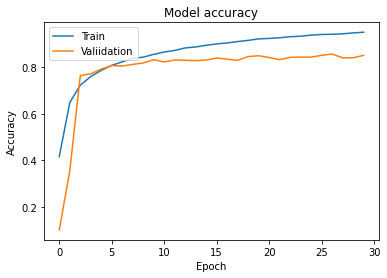

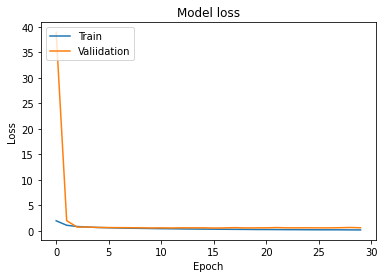

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()